In [ ]:
!pip install getFamaFrenchFactors

# Packages and plot functions

In [ ]:
import itertools

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns

import yfinance as yf
import statsmodels.api as sm
import getFamaFrenchFactors as gff
from statsmodels.tsa.vector_ar.vecm import coint_johansen

In [ ]:
np.random.seed(42)

plot_params = {'legend.fontsize': 20,
               'figure.figsize': (20, 12),
               'axes.labelsize':  15,
               'axes.titlesize':  20,
               'xtick.labelsize': 15,
               'ytick.labelsize': 15,
               'figure.dpi': 300}

plt.style.use('seaborn-v0_8')

plt.rcParams.update(plot_params)

color_dark_blue = [1/255, 62/255, 125/255]
color_light_blue = [6/255, 143/255, 203/255]
purple = [102/255, 51/255, 153/255]

colors = [color_dark_blue, color_light_blue, purple]

color_line = list(itertools.product(colors, ['-', ':', '--', ':' '-', ':']))

In [ ]:
def TimeSeriesPlot(y, lags=None, style='seaborn-v0_8-muted', y2=None):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):
        fig = plt.figure()
        layout = (2, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))

        y.plot(ax=ts_ax, color=color_dark_blue)
        ts_ax.set_title('Time Series Analysis Plots')
        sm.graphics.tsa.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.05, color=color_dark_blue)
        sm.graphics.tsa.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.05, color=color_dark_blue)

        if y2 is not None:
              if not isinstance(y2, pd.Series):
                  y2 = pd.Series(y2)
              y2.plot(ax=ts_ax, color=color_light_blue)
              sm.graphics.tsa.plot_acf(y2, lags=lags, ax=acf_ax, alpha=0.05, color=color_light_blue)
              sm.graphics.tsa.plot_pacf(y2, lags=lags, ax=pacf_ax, alpha=0.05, color=color_light_blue)

        plt.tight_layout()
    return

# Load Data

In [ ]:
ticker = 'msft'
start = '2016-8-31'
end = '2021-8-31'

stock_data = yf.download(ticker, start, end)

[*********************100%%**********************]  1 of 1 completed


In [ ]:
ff3_monthly = gff.famaFrench3Factor(frequency='m')
ff3_monthly.rename(columns={"date_ff_factors": 'Date'}, inplace=True)
ff3_monthly.set_index('Date', inplace=True)

In [ ]:
stock_returns = stock_data['Adj Close'].resample('M').last().pct_change().dropna()
stock_returns.name = "Month_Rtn"
ff_data = ff3_monthly.merge(stock_returns,on='Date')

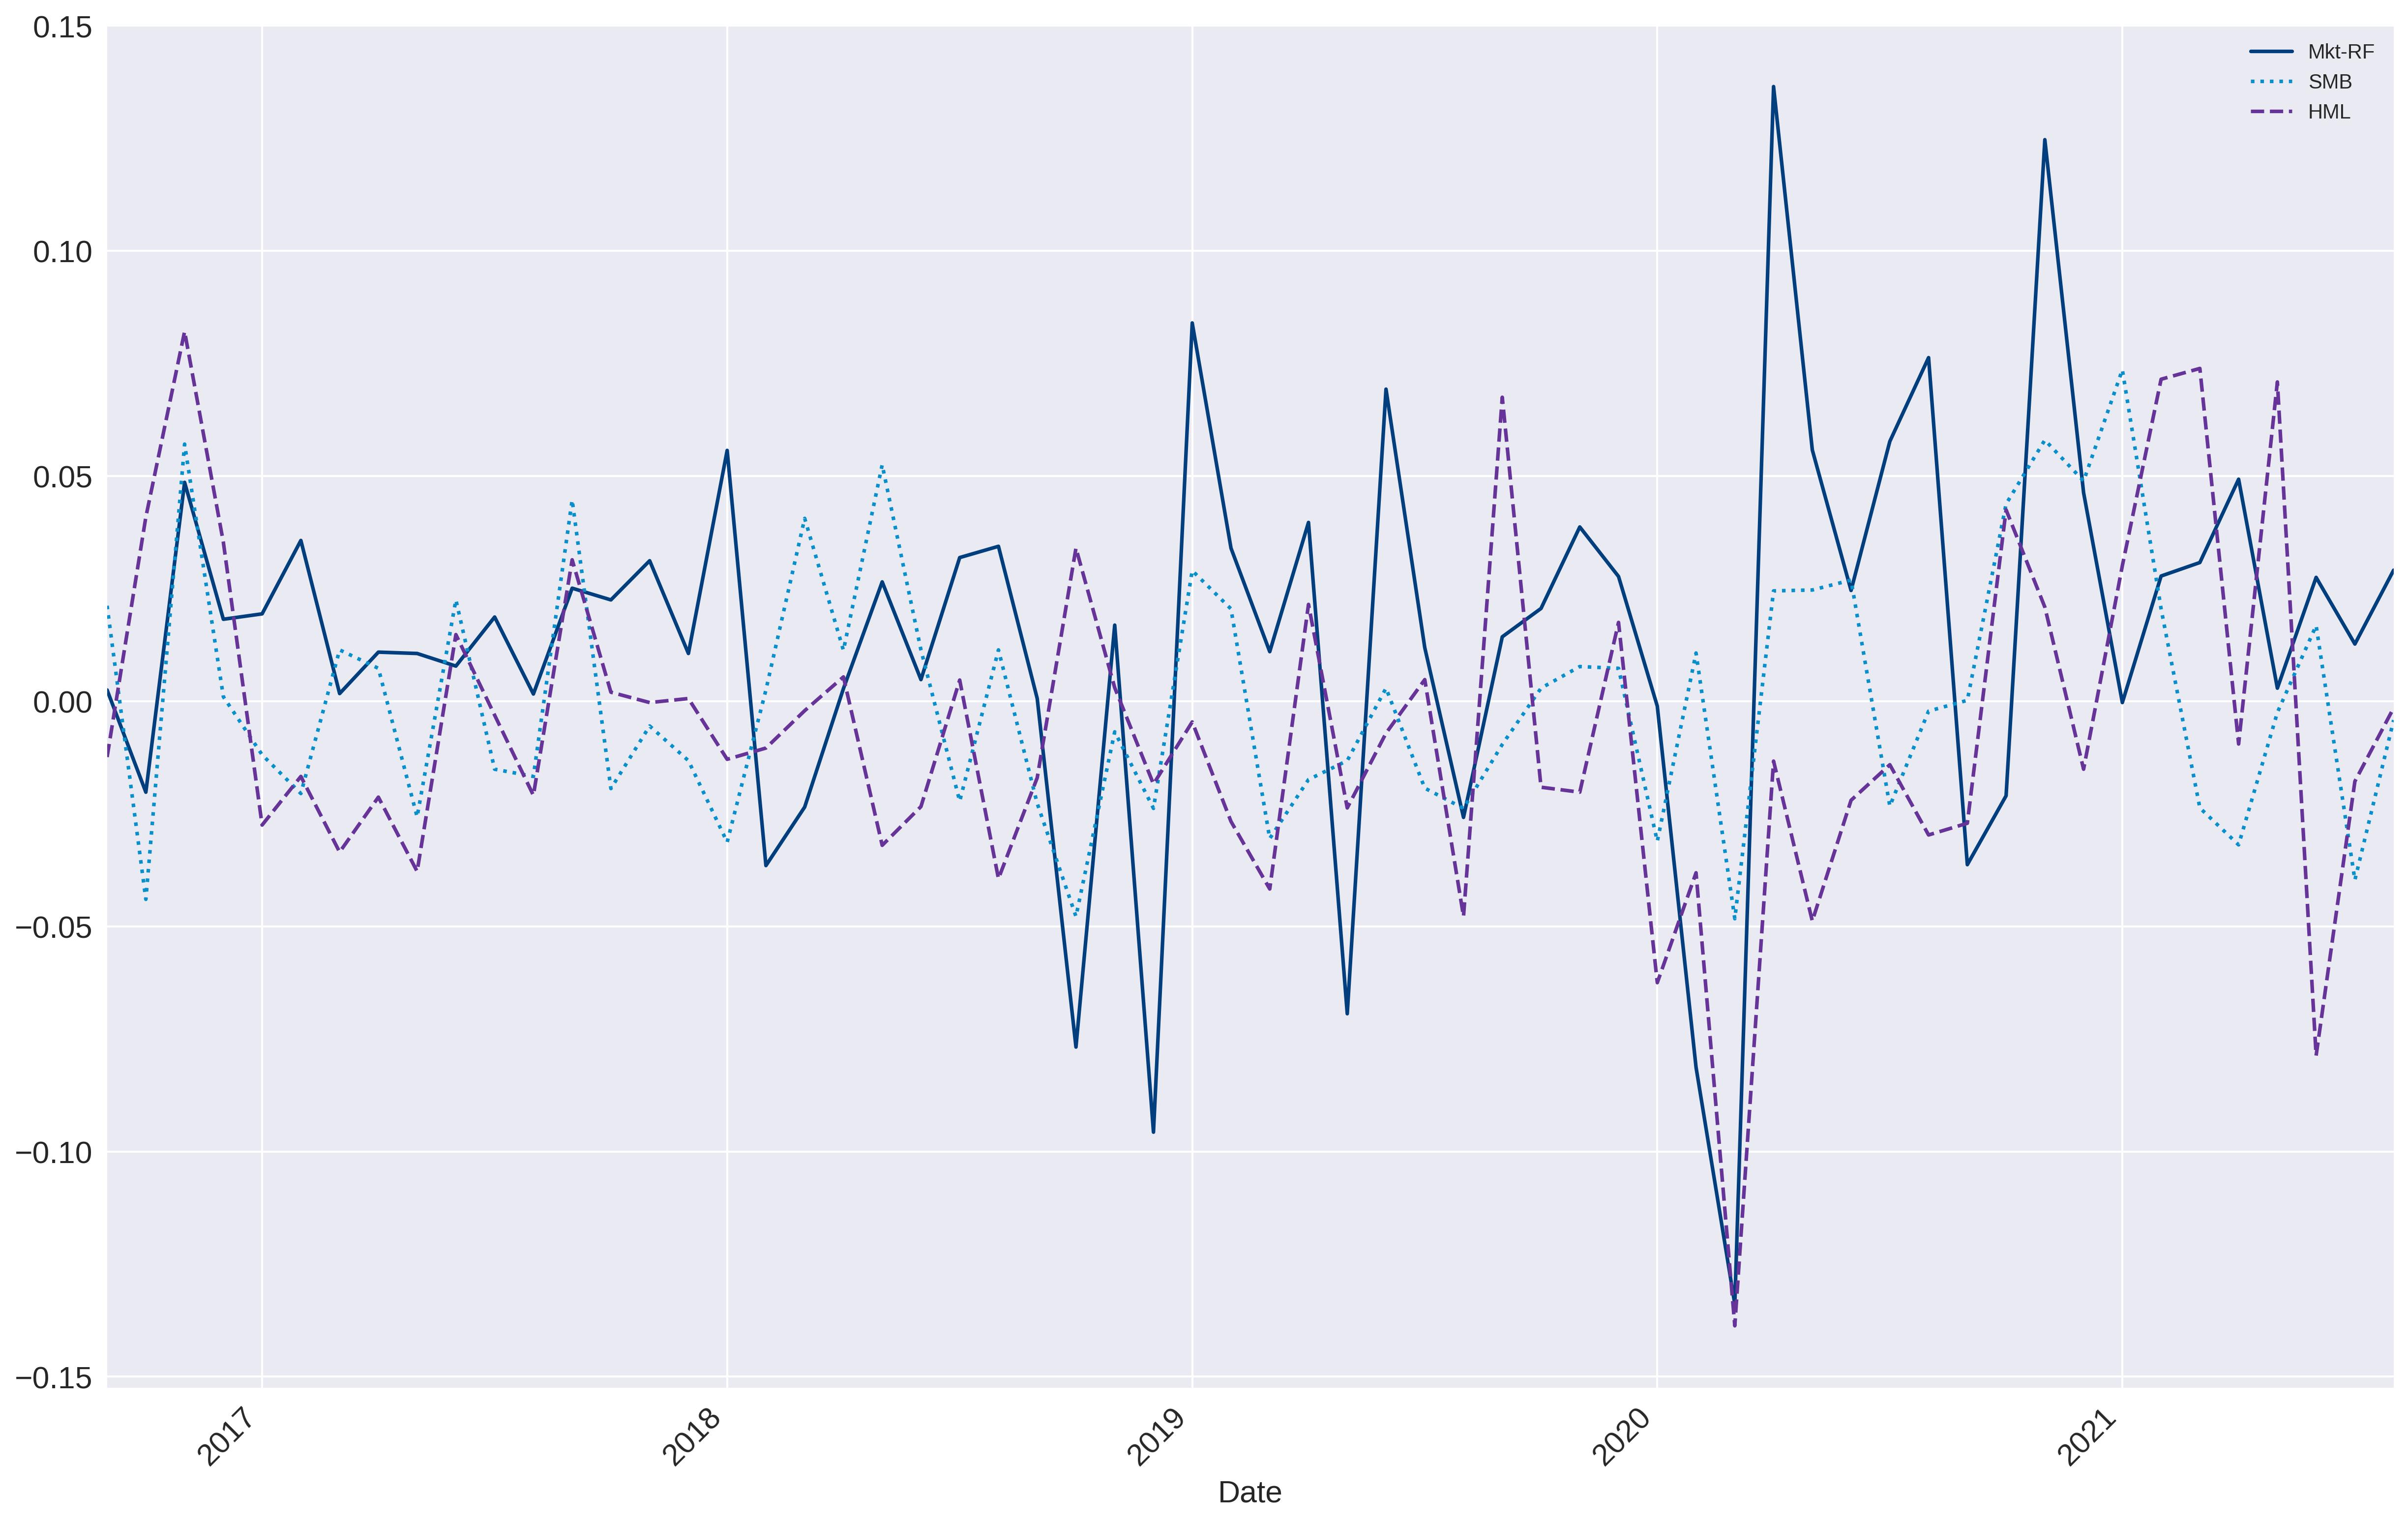

In [ ]:
for i in range(len(ff_data.columns[:3])):
  ff_data.iloc[:,i].plot(color=color_line[5*i][0], linestyle=color_line[i][1])
plt.legend(fontsize="10")
plt.xticks(rotation=45, ha='right')
plt.xlim([ff_data.index[0], ff_data.index[-1]]);

In [ ]:
X = ff_data[['Mkt-RF', 'SMB', 'HML']]
y = ff_data['Month_Rtn'] - ff_data['RF']
X = sm.add_constant(X)
ff_model = sm.OLS(y, X).fit()

In [ ]:
print(ff_model.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.608
Model:                            OLS   Adj. R-squared:                  0.587
Method:                 Least Squares   F-statistic:                     28.95
Date:                Thu, 07 Mar 2024   Prob (F-statistic):           1.95e-11
Time:                        03:02:28   Log-Likelihood:                 126.49
No. Observations:                  60   AIC:                            -245.0
Df Residuals:                      56   BIC:                            -236.6
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0155      0.004      3.668      0.0

In [ ]:
intercept, b1, b2, b3 = ff_model.params

rf = ff_data['RF'].mean()
market_premium = ff3_monthly['Mkt-RF'].mean()
size_premium = ff3_monthly['SMB'].mean()
value_premium = ff3_monthly['HML'].mean()

expected_monthly_return = rf + b1 * market_premium + b2 * size_premium + b3 * value_premium
expected_yearly_return = expected_monthly_return * 12
print("Expected yearly return: " + str(expected_yearly_return))

Expected yearly return: 0.06020813405136337


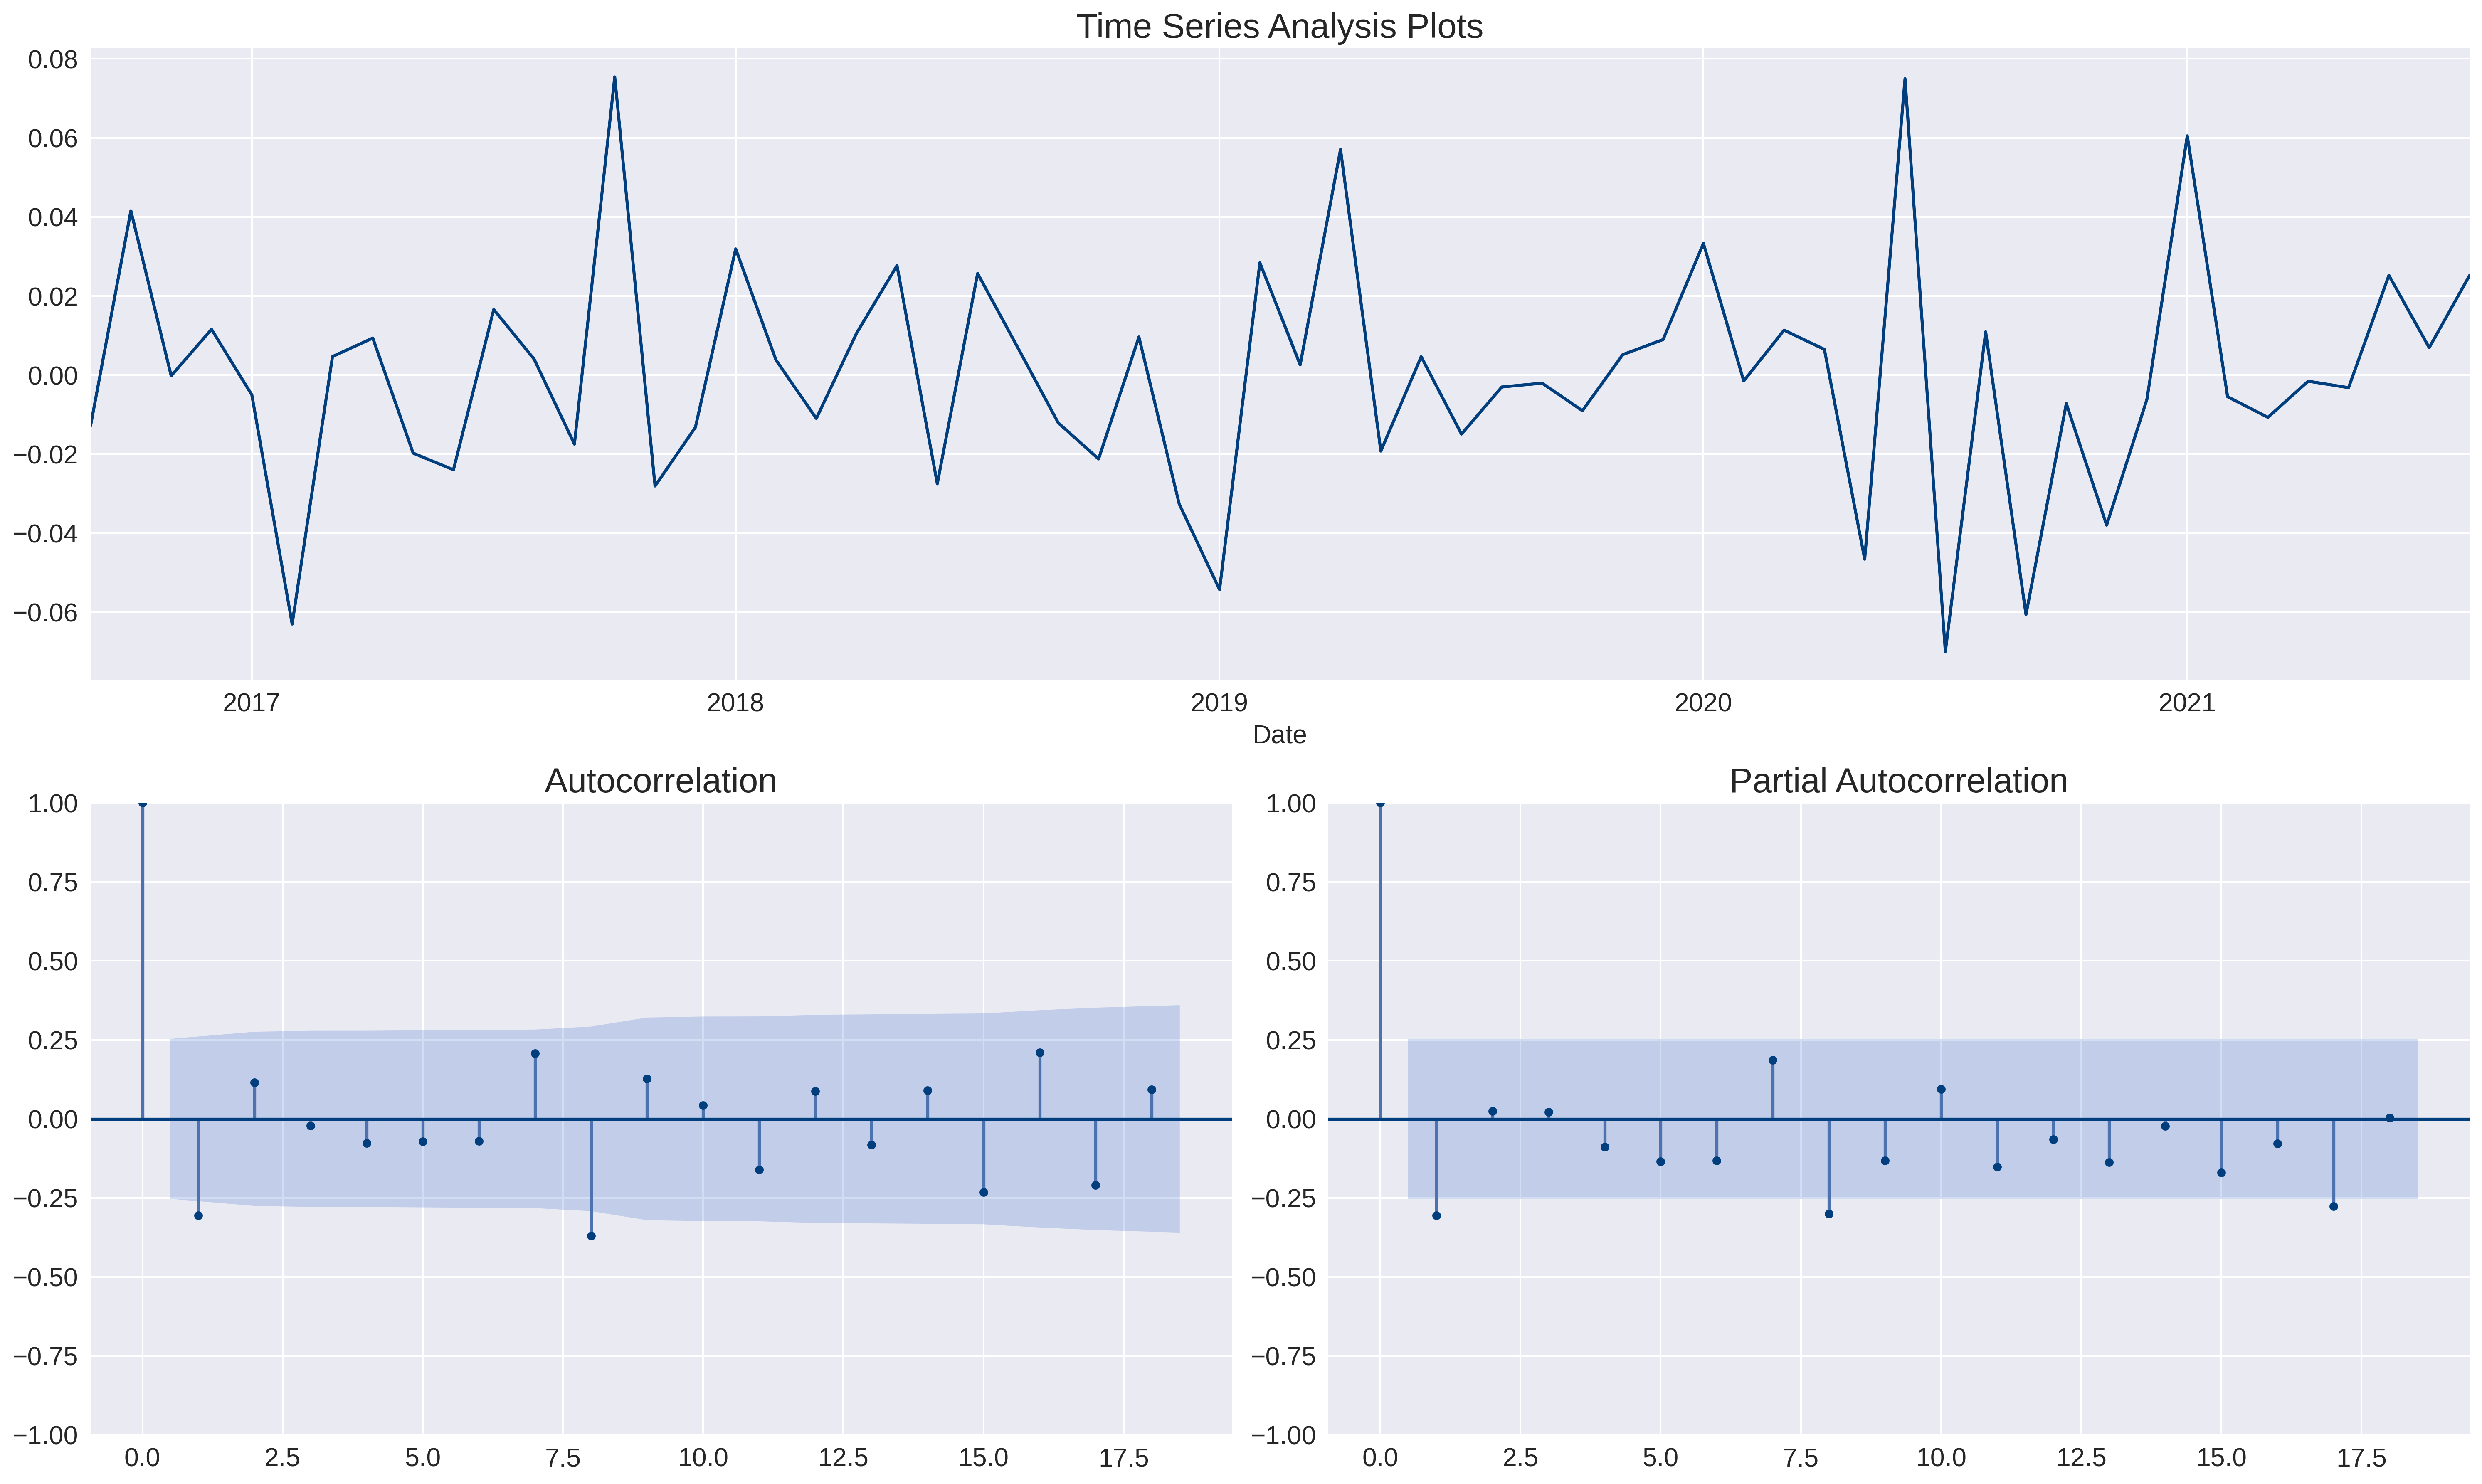

In [ ]:
TimeSeriesPlot(ff_model.resid)

In [ ]:
from statsmodels.stats.stattools import durbin_watson
durbin_watson(ff_model.resid)

2.5949152023094424